### Import required packages


In [9]:
import pandas as pd
import numpy as np
import os
import opendatasets as od
import librosa as li
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

### TO-DO:

- ~~Make function to convert string labels to int~~
- ~~Fix input pipeline to avoid training errors: "TypeError: 'str' object is not callable"~~
- ~~Add val_data value to model.train~~
- ~~Add cell for saving and loading the model~~

- Plot class distribution (chart with total audio duration for each label)
- Add callback to avoid overfitting
- Perform data augmentation on raw audio clips
- Compare Mel Spectrogram vs MFCC

### Import and Explore Dataset

Currently using the [British Birdsong Dataset](https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download).


Download sound files from Kaggle.

(Get kaggle.json API token from [here](https://www.kaggle.com/settings) an place it in the notebooks folder).


In [10]:
dataset_url = (
    "https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download"
)
path_to_download = "../datasets"

od.download(dataset_url, data_dir=path_to_download)

Skipping, found downloaded files in "../datasets\british-birdsong-dataset" (use force=True to force download)


Load labels and audio files. Split them to target size and append them to a list.


In [11]:
csv_path = path_to_download + '/british-birdsong-dataset/birdsong_metadata.csv'
sound_files_path = path_to_download + '/british-birdsong-dataset/songs/songs/'

metadata = pd.read_csv(csv_path)[['file_id', 'english_cname']]

audio_data = []
labels = []
original_durations = []

SAMPLE_RATE = 44100
LENGTH_SECONDS = 5

# For every file listed in the CSV...
for j in metadata.itertuples():
    # Read file and get duration
    filename = sound_files_path + 'xc' + str(j[1]) + '.flac'
    y, sr = li.load(filename, sr=None)
    duration = li.get_duration(y=y, sr=sr)

    # Append duration to list
    original_durations.append(duration)

    total_samples = sr * LENGTH_SECONDS

    # If longer than target duration, split it in segments and append it to list
    if duration > LENGTH_SECONDS:
        for i in range(int(duration / LENGTH_SECONDS) + 1):
            sample = y[i * total_samples: (i + 1) * total_samples]

            # Right pad to shorter samples
            if len(sample) < total_samples:
                sample = np.pad(
                    sample, (0, total_samples - len(sample)), 'constant')

            audio_data.append(sample)
            labels.append(j[2])

    # If shorter, right pad and append to list
    else:
        y = np.pad(y, (0, total_samples - len(y)), 'constant')
        audio_data.append(y)
        labels.append(j[2])

    # Wornig for files that not have the same sample rate
    if sr != SAMPLE_RATE:
        print(f'WARNING: Sample rate mismatch for xc{str(j[1])}.flac')

# Convert audio samples list to numpy array
audio_data = np.array(audio_data)

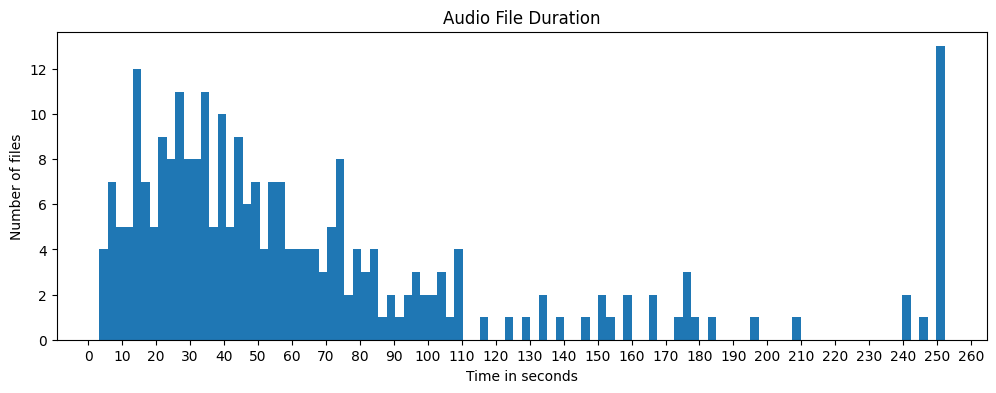

• Original file count: 264
• Total file count after splitting: 3678


In [12]:
# Plot histogram of original audio file durations
plt.subplots(figsize=(12, 4))
plt.title('Audio File Duration')
plt.xlabel('Time in seconds')
plt.ylabel('Number of files')
plt.xticks(range(0, 300, 10))
plt.hist(original_durations, bins=100)
plt.show()

print(f'• Original file count: {len(original_durations)}')
print(f'• Total file count after splitting: {len(audio_data)}')

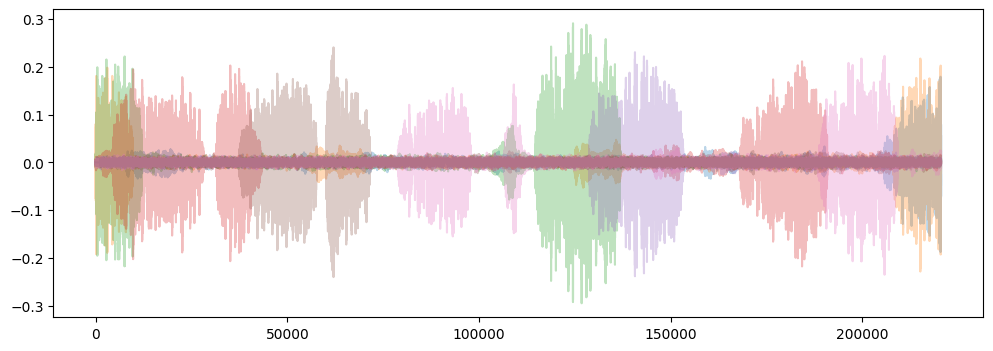

In [13]:
# Plot waveforms of several samples
plt.subplots(figsize=(12, 4))

for audio in audio_data[:7]:
    plt.plot(audio, alpha=0.3)

plt.show()

### Preprocess data


Convert string labels to int


In [14]:
# Returns a tuple containing an ordered list of encoded labels and a dictionary of unique labels as key and an int as value
def encode_labels(labels):
    unique_labels_list = {}

    for i, label in enumerate(set(labels)):
        unique_labels_list.update({label: i})

    full_label_list = []
    for label in labels:
        full_label_list.append(unique_labels_list[label])

    return (full_label_list, unique_labels_list)

In [15]:
encoded_labels, labels_dict = encode_labels(labels)

Convert audio time series in dataset to Mel spectrograms.


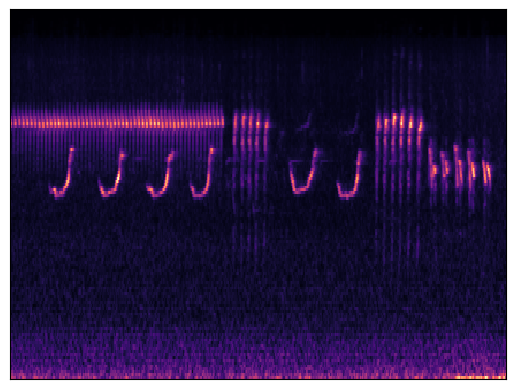

In [16]:
window_length = 2048
hop_length = 512

mel_spectrograms = []

for i in range(0, len(audio_data)):
    x = li.feature.melspectrogram(
        y=audio_data[i], sr=SAMPLE_RATE, n_fft=window_length, hop_length=hop_length, power=0.5, n_mels=128)
    mel_spectrograms.append(x)

np.array(mel_spectrograms)

li.display.specshow(mel_spectrograms[25])
plt.show()

Generate train-test-validation splits using sklearn.


In [17]:
SEED = 2505

x_train, x_test, y_train, y_test = train_test_split(mel_spectrograms, encoded_labels, test_size=0.25, random_state=SEED)

x_val = []

# Uncomment for further splitting test dataset into test-validation
# x_test, x_val, y_test, y_val = train_test_split(x_temp, y_train, test_size=0.2, random_state=SEED)

print(
    f'Train samples: {len(x_train)} - Test samples: {len(x_test)} - Validation samples {len(x_val)}')

Train samples: 2758 - Test samples: 920 - Validation samples 0


### Build and Train the model


Defining a simple CNN with 2x Conv+Maxpool + 1 Dense layers.

In [18]:
input_shape = x_train[0].shape
unique_class_count = len(metadata['english_cname'].unique())

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same',
                           activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same',
                           activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=unique_class_count, activation='softmax')
])

model.build()
model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 64)           82816     
                                                                 
 max_pooling1d (MaxPooling1  (None, 64, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 32, 128)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32, 128)           0

Training the model using train and test splits.

In [19]:
EPOCHS = 30
BATCH_SIZE = 16

history = model.fit(x=np.asarray(x_train), y=np.asarray(y_train),
                    validation_data=(np.asarray(x_test), np.asarray(y_test)), 
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

Plotting the training and validation accuracy and loss.

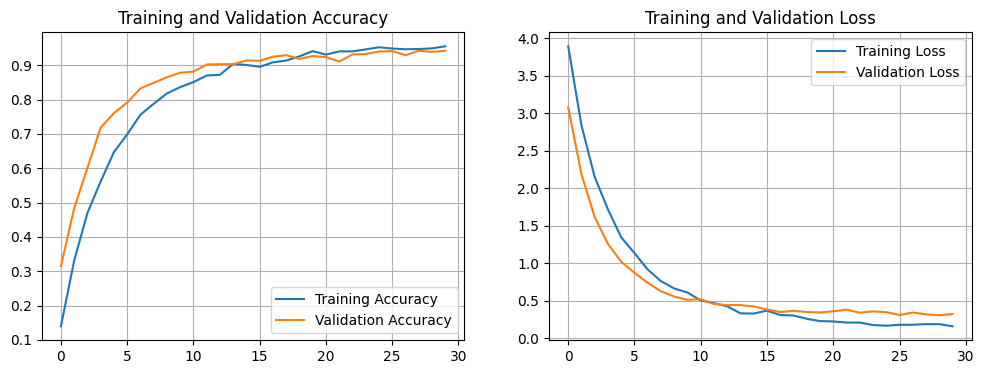

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.grid()
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

figure = plt.gcf()
plt.show()

Save model version.

In [21]:
model_name = str(input('Enter a title for the saved model...'))
model_path = f'../models/{model_name}/'

if model_name:
  try:
    os.mkdir(model_path)
    model.save(model_path + f'{model_name}.keras')
    print(f'Model successfully saved to {model_path}{model_name}.')
    
    # Remember to execute plotting cell first
    figure.savefig(model_path + f'{model_name}.png') 
  except:
    raise('ERROR: Model name is already in use. Pick another name and try again.')

Model successfully saved to ../models/02-cnn_british_dataset_30ep-5s_audio/02-cnn_british_dataset_30ep-5s_audio.


Load previously saved model.

In [ ]:
model_name = str(input('Type model name...'))

if model_name:
  model_path = f'../models/{model_name}/'

# model = tf.keras.models.load_model(model_path + f'{model_name}.keras')